#### setup

In [39]:
from __future__ import division
import numpy as np
import Quandl as qd
import pandas as pd
import scipy as sp
import numpy.random as npr
import scipy.stats as sps
from numpy import array
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from scipy import stats

#use seaborn plotting style defaults
import seaborn as sns; sns.set()

import copy
%matplotlib inline

import numpy.linalg as la

print sp.__version__

import os
os.getcwd()

import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

import pandas.io.data as web
from datetime import datetime

0.17.0


Import Functions From Seperate File

In [56]:
%run meeting1_functions.py

## Unconditional AR(1) with Known Varianace and Reference Prior

Make AR(1) with phi = .6 and v = 1

In [68]:
ar_data = make_test_arma([.4], [], 500)

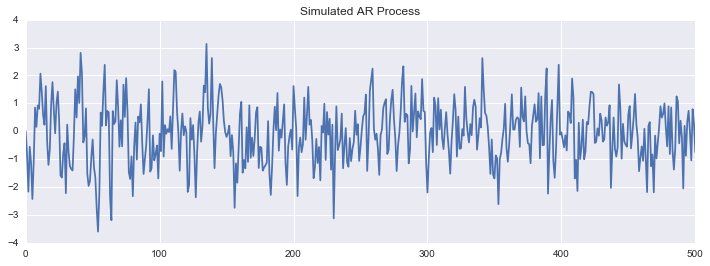

In [69]:
plt.figure(figsize=(12,4))
plt.plot(ar_data);
plt.title('Simulated AR Process');

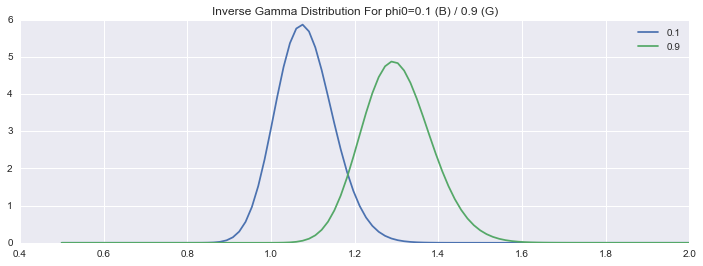

In [70]:
phi1 = .1
phi2 = .9

q1 = q_star_ar1_phi(ar_data, .1)
q2 = q_star_ar1_phi(ar_data, .9)

x = np.linspace(.5, 2, 100)

rv = stats.invgamma(len(ar_data)/2, scale=q1/2)
rv2 =  stats.invgamma(len(ar_data)/2, scale=q2/2)

plt.figure(figsize=(12,4))
plt.plot(x, rv.pdf(x), label=phi1)
plt.plot(x, rv2.pdf(x), label=phi2 )
plt.legend(loc='best')
plt.title('Inverse Gamma Distribution For phi0={0} (B) / {1} (G)'.format(phi1, phi2));


### Gibbs/MCMC 

In [91]:
%%time 

# set initial parameters
data = ar_data
phi0 = .9
v0 = 0
iterations = 5000

## in practice pick c to allow for an acceptance rate between 25 and, 40%
c = .1

# set up data to be collected
data_len = len(ar_data)
v_list = np.empty(iterations)
phi_list = np.empty(iterations)
v_list[0] = v0
phi_list[0] = phi0

r_list = np.zeros(iterations)

rejected = 0
rejected_oob = 0

for i in xrange(1, iterations):

    # Draw v from inverse gamma distribution v ~ IG(n/2 , Q*(phi)/2)
    # This is a Gibbs Step
    v = stats.invgamma.rvs(data_len/2, scale = q_star_ar1_phi(data, phi_list[i-1])/2)
    v_list[i] = v
    
    # draw phi from jump distribution with phi* ~ N(phi[-1], cv)
    # metropolis step
    phi_new = np.random.randn()* np.sqrt(c * v) + phi_list[i-1]
    
    # reject if phi is drawn such that abs(phi) > 1
    # if this isn't there the algo won't run because it will move into the complex space
    # which I haven't accounted for
    if -1 <= phi_new <= 1:
        
        # calculate r as ratio of likelihoods for new and old phi
        r = calc_likelihood(data, phi_new, v) / calc_likelihood(data, phi_list[i-1], v)
        r_list[i] = r
        
        # only accept new phi with probability r
        if r < np.random.rand(): #draw from uniform dist over [0,1]
            rejected +=1
            phi_new = phi_list[i-1]
            
    else:
        phi_new = phi_list[i-1]
        rejected += 1
        rejected_oob += 1
    
    phi_list[i] = phi_new

print 'iterations = ', iterations
print 'acceptance = ', iterations - rejected
print 'out of bounds = ', rejected_oob

iterations =  5000
acceptance =  2010
out of bounds =  304
CPU times: user 4.87 s, sys: 32.3 ms, total: 4.9 s
Wall time: 4.88 s


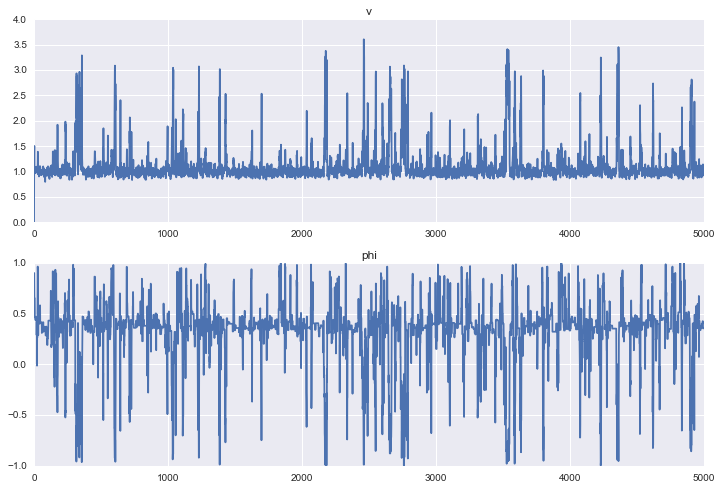

In [92]:
burn = 0
until = -1 
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(v_list[burn:until]);
plt.title('v');
plt.subplot(212)
plt.plot(phi_list[burn:until]);
plt.title('phi');

Check Fits

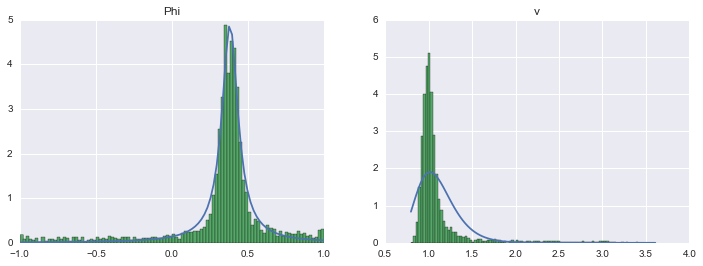

In [93]:
burn = 10

plt.figure(figsize=(12,4))

plt.subplot(121)

fit_t_dist(phi_list[burn:], plot=True)
plt.hist(phi_list[burn:], 100, normed=True);
#plt.xlim((0, 3))
plt.title('Phi')

plt.subplot(122)

fit_invgamma_dist(v_list[burn:], True)
plt.hist(v_list[burn:], 100, normed=True);
#plt.xlim((1,2))
plt.title("v")

check for estimation value

In [82]:
t_dist = fit_t_dist(phi_list[burn:])
t_dist.mean()

0.38260987670370494

In [83]:
ig_dist = fit_invgamma_dist(v_list[burn:])
ig_dist.mean()

1.0047305913537097

In [95]:
h = array([1,2,3,54, .1])

In [99]:
h += 1

## Example 2